In [2]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
TRAIN_PATH = './fingers/train/*'
TEST_PATH = './fingers/test/*'
FILE_NAME = 'fingers_detection.keras'
MODEL_PATH = 'fingers_detection_model/'
KERNEL = (3,3)
CLASSES = 6
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

# filePathDigit | label/class -> Meaning/feature 
# 0 | 0 -> 0 finger (other)
# 1 | 1 -> 1 finger 
# 2 | 2 -> 2 finger 
# 3 | 3 -> 3 finger 
# 4 | 4 -> 4 finger 
# 5 | 5 -> 5 finger 

In [ ]:
def load_dataset(path):
    dataset = [(int(img_path[-6]), load_image(img_path)) for img_path in glob.glob(path)]
    return dataset

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def show_images(dataset, grid_size=5):
    _, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = [y for x in axes for y in x]
    for (i, (label, img)) in enumerate(random.sample(dataset, grid_size**2)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')

def process_image(img):
    # Resize image to uniform size
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # Normalize pixel values to [0, 1]
    img = img.astype(np.float32) / 255.0 # basically img is numpy array (lets say 2x2 with integer values 0[black] - 255[white] ) so we convert each interger into 32-bit floating point number and then divide each float with 255 so each of them becomes in the range (0-1) e.g: 0.47058824, 0.9411765)
    # Add channel dimension for compatibility with models expecting (H, W, 1)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1)) # 1 means single channel so it becomes (height, width, channels)
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset


In [10]:
train_set = load_dataset(TRAIN_PATH)
test_set = load_dataset(TEST_PATH)

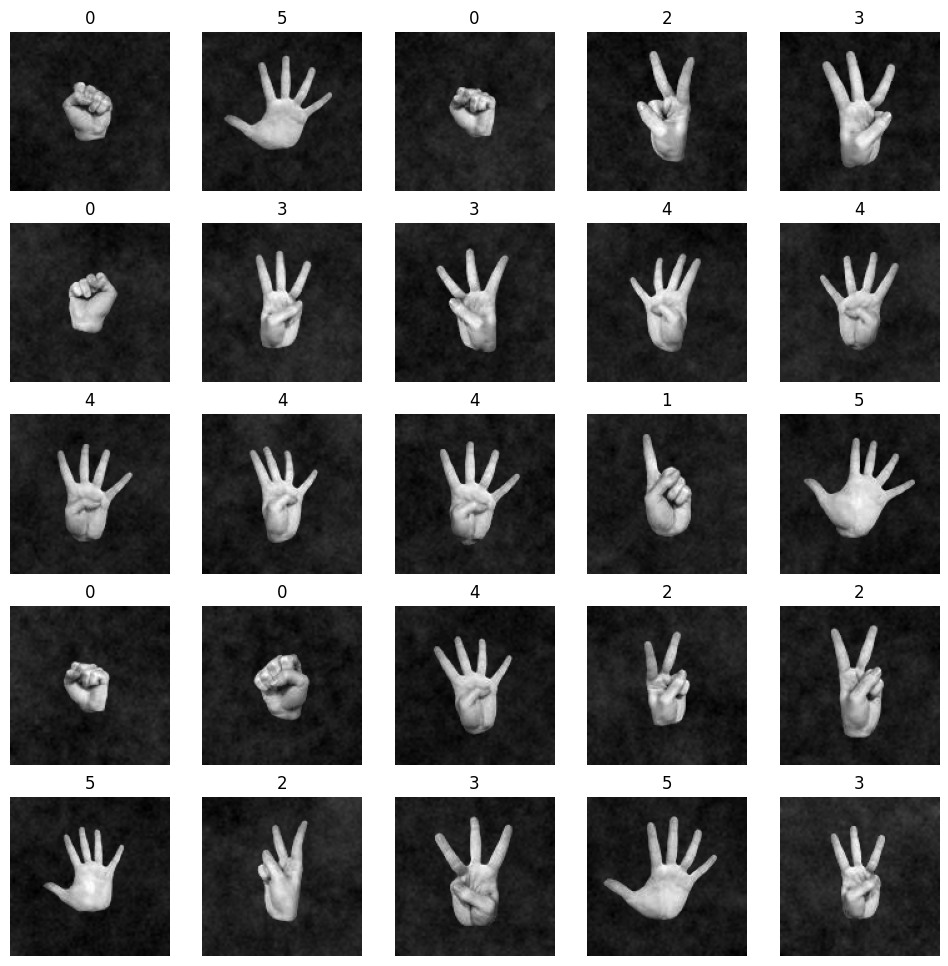

In [11]:
show_images(train_set)

In [12]:
training_set = process_dataset(train_set)
testing_set = process_dataset(test_set)

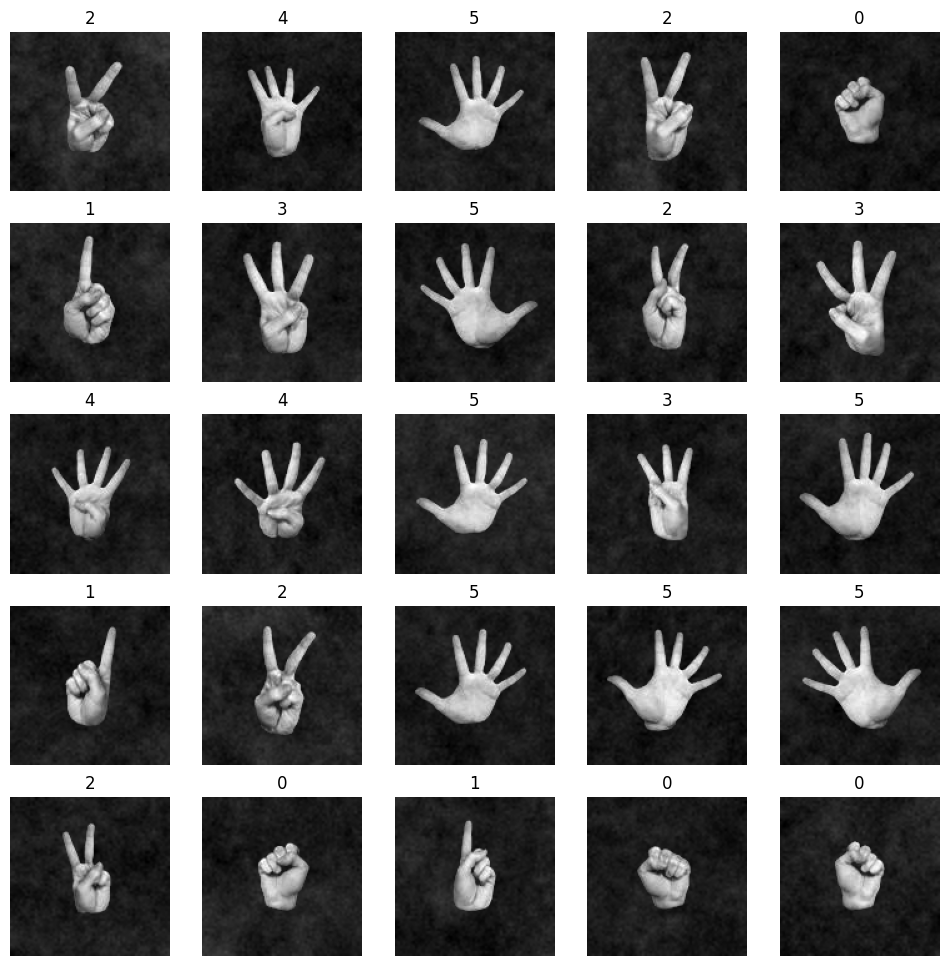

In [7]:
# basically again showing few images after processing dataset (resizing,normalizing,reshaping etc)
show_images(training_set)  

In [13]:
# converting  the training and testing datasets from a list of tuples into separate 
# NumPy arrays for features (images) and labels.
# x->image(feature) and y->label
X_train = np.array([img for (_, img) in training_set])
Y_train = keras.utils.to_categorical([label for (label, _) in training_set], num_classes=CLASSES)
X_test = np.array([img for (_, img) in testing_set])
Y_test = keras.utils.to_categorical([label for (label, _) in testing_set], num_classes=CLASSES)

In [14]:
print(X_train.shape)
print(Y_train.shape)

(18000, 128, 128, 1)
(18000, 6)


In [20]:
# For data augmentation ( to generalize the model better )
img_generator = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

In [21]:
def get_model():
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]
        
    model = keras.models.Sequential([
            Input(input_shape),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(256, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.2),
            Flatten(),
            Dense(CLASSES, activation="softmax"),
        ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [22]:
checkpoint = ModelCheckpoint(FILE_NAME, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

model = get_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        13,830 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,062 (2.03 MB)

 Trainable params: 532,038 (2.03 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
history = model.fit(
        x = img_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
        steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
        validation_data= img_generator.flow(X_test, Y_test, batch_size=BATCH_SIZE),
        validation_steps= X_test.shape[0] // BATCH_SIZE,
        epochs= EPOCHS,
        callbacks= callbacks_list
    )

Epoch 1/50


c:\Users\maazk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6885 - loss: 0.8242
Epoch 1: loss improved from inf to 0.50560, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - accuracy: 0.6887 - loss: 0.8237 - val_accuracy: 0.5946 - val_loss: 1.0679 - learning_rate: 1.0000e-04
Epoch 2/50
  1/562 ━━━━━━━━━━━━━━━━━━━━ 7:29 801ms/step - accuracy: 0.9375 - loss: 0.2373

c:\Users\maazk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: loss improved from 0.50560 to 0.23731, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.9375 - loss: 0.2373 - val_accuracy: 0.5991 - val_loss: 1.0907 - learning_rate: 1.0000e-04
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9398 - loss: 0.1935
Epoch 3: loss improved from 0.23731 to 0.16731, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 658s 1s/step - accuracy: 0.9398 - loss: 0.1935 - val_accuracy: 0.9821 - val_loss: 0.0971 - learning_rate: 1.0000e-04
Epoch 4/50
  1/562 ━━━━━━━━━━━━━━━━━━━━ 11:23 1s/step - accuracy: 0.9375 - loss: 0.1443
Epoch 4: loss improved from 0.16731 to 0.14429, saving model to fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 74s 129ms/step - accuracy: 0.9375 - loss: 0.1443 - val_accuracy: 0.9796 - val_loss: 0.1028 - learning_rate: 1.0000e-04
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9714 - loss: 0.1087
Epoch 5: loss improved from 0.14429 

In [24]:
tf.saved_model.save(model, MODEL_PATH)
print("Model Saved at path:" + MODEL_PATH)

INFO:tensorflow:Assets written to: fingers_detection_model/assets


INFO:tensorflow:Assets written to: fingers_detection_model/assets


Model Saved at path:fingers_detection_model/


In [25]:
model = load_model("fingers_detection.keras")
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 200ms/step - accuracy: 1.0000 - loss: 0.0081
Test Accuracy: 0.9997
Test Loss: 0.0084


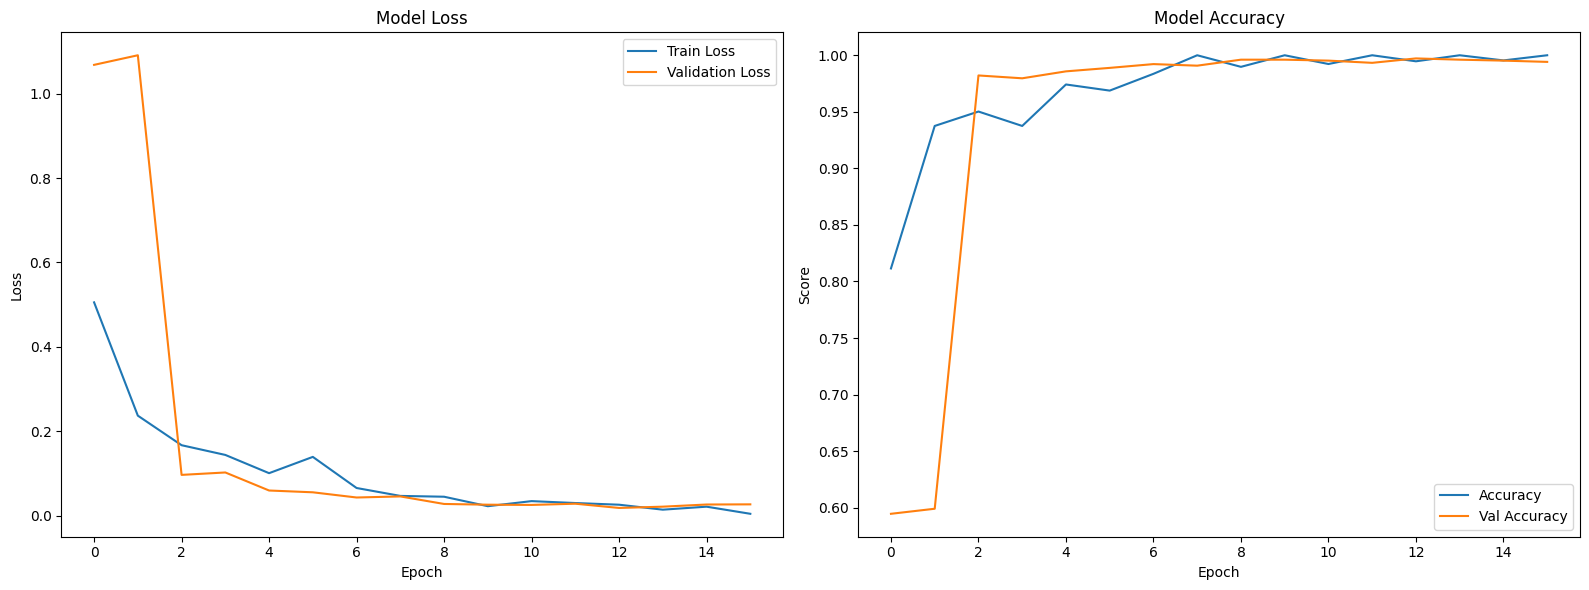

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


In [27]:
class FingerClassifier(object):
    def __init__(self, model_object):
        self.detect = model_object

    def get_classification(self, img):
        img = img.reshape(1, *img.shape)
        img = tf.constant(img, dtype=float)
        unique, counts = np.unique(img, return_counts=True)
        if (len(counts) <= 1 or counts[1] < 1200):
            return -1;
        output = self.detect(img)
        return np.argmax(output)

In [28]:
obj = FingerClassifier(model)